## Particle tracking through a steady-state system with lateral flow boundaries and a refined vertex grid.

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 4 from the MODPATH 7 documentation.

This notebook demonstrates a steady-state MODFLOW 6 simulation using a quadpatch DISV grid with an irregular domain and a large number of inactive cells. Particles are tracked backwards from terminating locations, including a pair of wells in a locally-refined region of the grid and constant-head cells along the grid's right side, to release locations along the left border of the grid's active region. Injection wells along the left-hand border are used to generate boundary flows.

### Problem setup

First import dependencies.

In [25]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, LineString
import flopy
from flopy.utils.gridintersect import GridIntersect
import numpy as np
from pathlib import Path

# append the common/ subdirectory to the system path
sys.path.append(os.path.join("..", "common"))
import config
from figspecs import USGSFigure

Define workspace paths and model/file-names.

In [26]:
sim_name = "mp7-p04"
gwf_name = sim_name
prt_name = sim_name + "_prt"
example_name = "ex-prt-" + sim_name

ws = config.base_ws
sim_ws = Path(ws) / example_name
gwf_ws = sim_ws / "mf6gwf"
prt_ws = sim_ws / "mf6prt"
mp7_ws = sim_ws / "mp7"

gwf_ws.mkdir(exist_ok=True, parents=True)
prt_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

headfile = f"{gwf_name}.hds"
headfile_bkwd = f"{gwf_name + '_bkwd'}.hds"
budgetfile = f"{gwf_name}.bud"
budgetfile_bkwd = f"{gwf_name + '_bkwd'}.bud"
trackfile_prt = f"{prt_name}.trk"
budgetfile_prt = f"{prt_name}.cbb"
pathlinefile_mp7 = f"{sim_name}_mp.mppth"

### Grid refinement

[GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) can be used to create a quadpatch grid with a refined region in the upper left quadrant.

We will create a grid with 3 refinement levels, all nearly but not perfectly rectangular: a 500x500 area is carved out of the corners of the rectangle for each level. To form each region's polygon we combine 5 rectangles.

Create the top-level grid discretization.

In [27]:
nlay, nrow, ncol = 1, 21, 26
delr = delc = 500.0
top = 100.0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Refine the grid. Create a Gridgen object from the base grid, then add refinement features.

In [28]:
from flopy.utils.gridgen import Gridgen

# create Gridgen workspace
gridgen_ws = sim_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws=gridgen_ws, exe_name=config.gridgen_exe)

# add polygon for each refinement level
outer_polygon = [
    [
        (2500, 6000),
        (2500, 9500),
        (3000, 9500),
        (3000, 10000),
        (6000, 10000),
        (6000, 9500),
        (6500, 9500),
        (6500, 6000),
        (6000, 6000),
        (6000, 5500),
        (3000, 5500),
        (3000, 6000),
        (2500, 6000),
    ]
]
g.add_refinement_features([outer_polygon], "polygon", 1, range(nlay))
refshp0 = gridgen_ws / "rf0"

middle_polygon = [
    [
        (3000, 6500),
        (3000, 9000),
        (3500, 9000),
        (3500, 9500),
        (5500, 9500),
        (5500, 9000),
        (6000, 9000),
        (6000, 6500),
        (5500, 6500),
        (5500, 6000),
        (3500, 6000),
        (3500, 6500),
        (3000, 6500),
    ]
]
g.add_refinement_features([middle_polygon], "polygon", 2, range(nlay))
refshp1 = gridgen_ws / "rf1"

inner_polygon = [
    [
        (3500, 7000),
        (3500, 8500),
        (4000, 8500),
        (4000, 9000),
        (5000, 9000),
        (5000, 8500),
        (5500, 8500),
        (5500, 7000),
        (5000, 7000),
        (5000, 6500),
        (4000, 6500),
        (4000, 7000),
        (3500, 7000),
    ]
]
g.add_refinement_features([inner_polygon], "polygon", 3, range(nlay))
refshp2 = gridgen_ws / "rf2"

Build the grid and plot it with refinement levels superimposed.

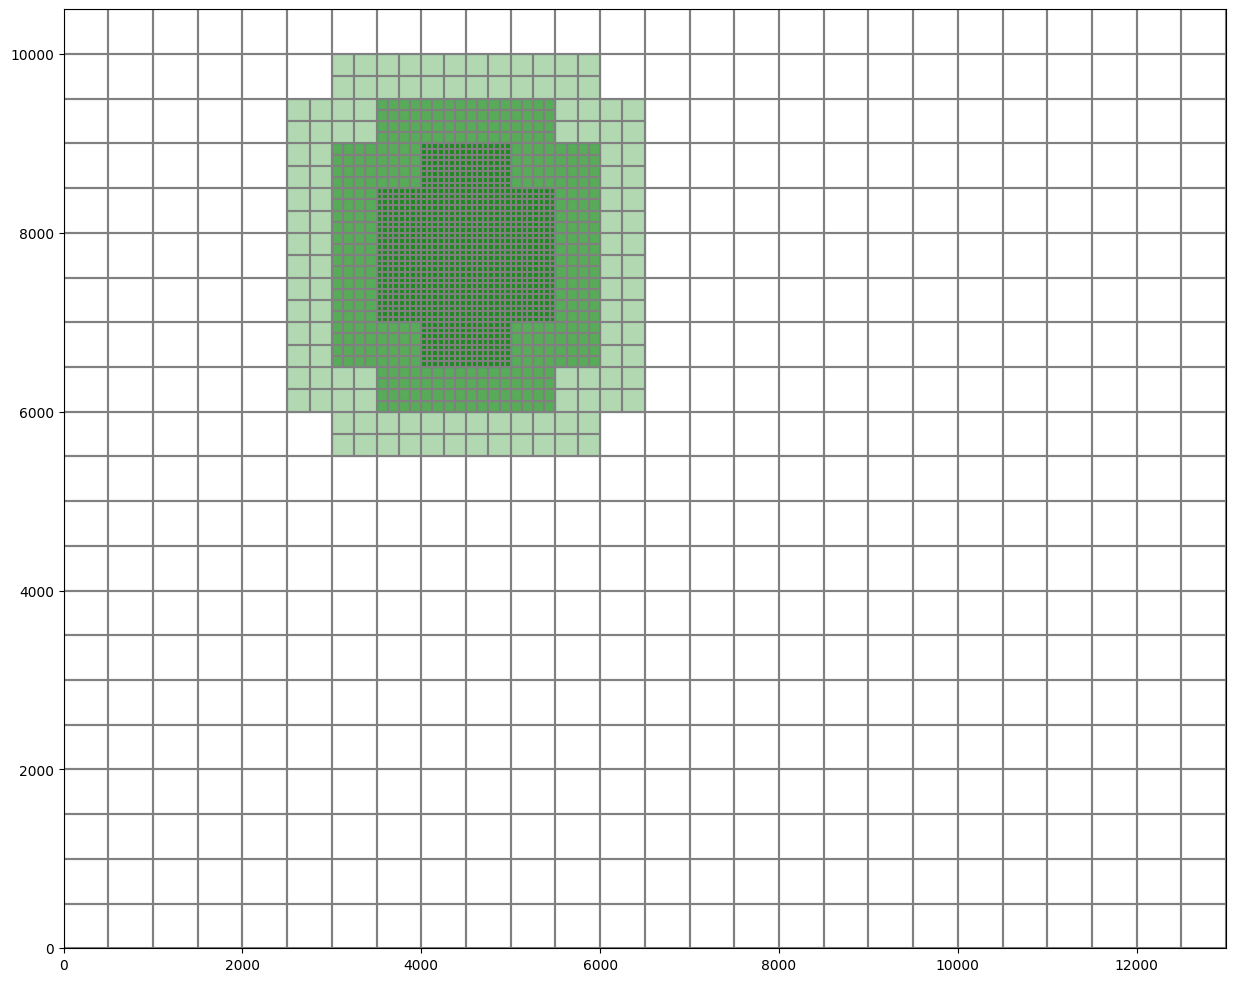

In [29]:
g.build(verbose=False)
grid = flopy.discretization.VertexGrid(**g.get_gridprops_vertexgrid())

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(model=ms)
grid.plot(ax=ax)

flopy.plot.plot_shapefile(refshp0, ax=ax, facecolor="green", alpha=0.3)
flopy.plot.plot_shapefile(refshp1, ax=ax, facecolor="green", alpha=0.5)
flopy.plot.plot_shapefile(str(refshp2), ax=ax, facecolor="green", alpha=0.7)

We are now ready to set up groundwater flow and particle tracking models.

Define shared variables, including discretization parameters, idomain, and porosity.

In [30]:
porosity = 0.1
nper = 1
tdis_rc = [(10000, 1, 1.0)]
# fmt: off
idomain = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
    0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0
]
# fmt: on
disv_props = g.get_gridprops_disv()

from pprint import pprint
pprint(idomain, compact=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Define well locations and flows.

In [31]:
wells = [
    # negative q: discharge
    (0, 861, -30000.0, 0, -1),
    (0, 891, -30000.0, 0, -1),
    # positive q: injection
    (0, 1959, 10000.0, 1, 4),
    (0, 1932, 10000.0, 3, 3),
    (0, 1931, 10000.0, 3, 3),
    (0, 1930, 5000.0, 1, 4),
    (0, 1930, 5000.0, 3, 3),
    (0, 1903, 5000.0, 1, 4),
    (0, 1903, 5000.0, 3, 3),
    (0, 1876, 10000.0, 3, 3),
    (0, 1875, 10000.0, 3, 3),
    (0, 1874, 5000.0, 1, 4),
    (0, 1874, 5000.0, 3, 3),
    (0, 1847, 10000.0, 3, 3),
    (0, 1846, 10000.0, 3, 3),
    (0, 1845, 5000.0, 1, 4),
    (0, 1845, 5000.0, 3, 3),
    (0, 1818, 5000.0, 1, 4),
    (0, 1818, 5000.0, 3, 3),
    (0, 1792, 10000.0, 1, 4),
    (0, 1766, 10000.0, 1, 4),
    (0, 1740, 5000.0, 1, 4),
    (0, 1740, 5000.0, 4, 1),
    (0, 1715, 5000.0, 1, 4),
    (0, 1715, 5000.0, 4, 1),
    (0, 1690, 10000.0, 1, 4),
    (0, 1646, 5000.0, 1, 4),
    (0, 1646, 5000.0, 4, 1),
    (0, 1549, 5000.0, 1, 4),
    (0, 1549, 5000.0, 4, 1),
    (0, 1332, 5000.0, 4, 1),
    (0, 1332, 5000.0, 1, 5),
    (0, 1021, 2500.0, 1, 4),
    (0, 1021, 2500.0, 4, 1),
    (0, 1020, 5000.0, 1, 5),
    (0, 708, 2500.0, 1, 5),
    (0, 708, 2500.0, 4, 1),
    (0, 711, 625.0, 1, 4),
    (0, 711, 625.0, 4, 1),
    (0, 710, 625.0, 1, 4),
    (0, 710, 625.0, 4, 1),
    (0, 409, 1250.0, 1, 4),
    (0, 407, 625.0, 1, 4),
    (0, 407, 625.0, 4, 1),
    (0, 402, 625.0, 1, 4),
    (0, 402, 625.0, 4, 1),
    (0, 413, 1250.0, 1, 4),
    (0, 411, 1250.0, 1, 4),
    (0, 203, 1250.0, 1, 5),
    (0, 203, 1250.0, 4, 1),  # added (fix)
    (0, 202, 1250.0, 1, 4),
    (0, 202, 1250.0, 4, 1),
    (0, 199, 2500.0, 1, 4),
    (0, 197, 1250.0, 1, 4),
    (0, 197, 1250.0, 4, 1),
    (0, 96, 2500.0, 1, 4),
    (0, 96, 2500.0, 4, 1),  # added (fix)
    (0, 98, 1250.0, 1, 4),
    # (0, 98, 1250.0, 4, 1),  # removed (fix)
    (0, 101, 1250.0, 1, 4),
    (0, 101, 1250.0, 4, 1),
    (0, 100, 1250.0, 1, 4),
    (0, 100, 1250.0, 4, 1),
    (0, 43, 2500.0, 1, 4),
    (0, 43, 2500.0, 4, 1),
    (0, 44, 2500.0, 1, 4),
    (0, 44, 2500.0, 4, 1),
    (0, 45, 5000.0, 4, 1),
    (0, 10, 10000.0, 1, 5),
]

assert len(wells) == 68

Define a function to build the groundwater flow model.

In [32]:
def build_gwf():
    print("Building GWF model")

    # simulation
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=gwf_ws, exe_name=config.mf6_exe, version="mf6"
    )

    # temporal discretization
    tdis = flopy.mf6.ModflowTdis(sim, time_units="days", nper=nper, perioddata=tdis_rc)

    # iterative model solver
    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-4,
        outer_maximum=100,
        inner_dvclose=1e-5,
        under_relaxation_theta=0,
        under_relaxation_kappa=0,
        under_relaxation_gamma=0,
        under_relaxation_momentum=0,
        linear_acceleration="BICGSTAB",
        relaxation_factor=0.99,
        number_orthogonalizations=2,
    )

    # groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, model_nam_file=f"{sim_name}.nam", save_flows=True
    )

    # grid discretization
    disv = flopy.mf6.ModflowGwfdisv(gwf, length_units="feet", idomain=idomain, **disv_props)

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=150.0)

    flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf,
        maxbound=len(wells),
        auxiliary=["IFACE", "IFLOWFACE"],
        save_flows=True,
        stress_period_data={0: wells},
    )

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=True,
        save_flows=True,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=[0],
        k=[50],
    )

    # constant head boundary (period, node number, head)
    chd_bound = [
        (0, 1327, 150.0),
        (0, 1545, 150.0),
        (0, 1643, 150.0),
        (0, 1687, 150.0),
        (0, 1713, 150.0),
    ]
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        pname="chd",
        save_flows=True,
        stress_period_data=chd_bound,
        # auxiliary=["IFLOWFACE"]
    )

    # output control
    budget_file = f"{sim_name}.bud"
    head_file = f"{sim_name}.hds"
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        pname="oc",
        budget_filerecord=[budget_file],
        head_filerecord=[head_file],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    return sim

Next we can define the particle-tracking model. This example problem uses a reverse-tracking model, in which termination and release zones are swapped: we "release" (terminate) particles in the constant head boundary on the grid's right edge and the two pumping wells, and track them backwards to "termination" (release) locations at the wells along the left boundary of the active domain.

Define particle release locations, initially in the representation for MODPATH 7 particle input style 1.

In [33]:
# define particles in MODPATH 7 input style 1
# each particle is a tuple (node number, localx, localy, localz)
particles = [
    (1327, 0.000, 0.125, 0.500),
    (1327, 0.000, 0.375, 0.500),
    (1327, 0.000, 0.625, 0.500),
    (1327, 0.000, 0.875, 0.500),
    (1545, 0.000, 0.125, 0.500),
    (1545, 0.000, 0.375, 0.500),
    (1545, 0.000, 0.625, 0.500),
    (1545, 0.000, 0.875, 0.500),
    (1643, 0.000, 0.125, 0.500),
    (1643, 0.000, 0.375, 0.500),
    (1643, 0.000, 0.625, 0.500),
    (1643, 0.000, 0.875, 0.500),
    (1687, 0.000, 0.125, 0.500),
    (1687, 0.000, 0.375, 0.500),
    (1687, 0.000, 0.625, 0.500),
    (1687, 0.000, 0.875, 0.500),
    (1713, 0.000, 0.125, 0.500),
    (1713, 0.000, 0.375, 0.500),
    (1713, 0.000, 0.625, 0.500),
    (1713, 0.000, 0.875, 0.500),
    (861, 0.000, 0.125, 0.500),
    (861, 0.000, 0.375, 0.500),
    (861, 0.000, 0.625, 0.500),
    (861, 0.000, 0.875, 0.500),
    (861, 1.000, 0.125, 0.500),
    (861, 1.000, 0.375, 0.500),
    (861, 1.000, 0.625, 0.500),
    (861, 1.000, 0.875, 0.500),
    (861, 0.125, 0.000, 0.500),
    (861, 0.375, 0.000, 0.500),
    (861, 0.625, 0.000, 0.500),
    (861, 0.875, 0.000, 0.500),
    (861, 0.125, 1.000, 0.500),
    (861, 0.375, 1.000, 0.500),
    (861, 0.625, 1.000, 0.500),
    (861, 0.875, 1.000, 0.500),
    (891, 0.000, 0.125, 0.500),
    (891, 0.000, 0.375, 0.500),
    (891, 0.000, 0.625, 0.500),
    (891, 0.000, 0.875, 0.500),
    (891, 1.000, 0.125, 0.500),
    (891, 1.000, 0.375, 0.500),
    (891, 1.000, 0.625, 0.500),
    (891, 1.000, 0.875, 0.500),
    (891, 0.125, 0.000, 0.500),
    (891, 0.375, 0.000, 0.500),
    (891, 0.625, 0.000, 0.500),
    (891, 0.875, 0.000, 0.500),
    (891, 0.125, 1.000, 0.500),
    (891, 0.375, 1.000, 0.500),
    (891, 0.625, 1.000, 0.500),
    (891, 0.875, 1.000, 0.500),
]

For vertex grids, the MODFLOW 6 PRT model's PRP (particle release point) package expects initial particle locations as tuples `(particle ID, (layer, cell ID), x coord, y coord, z coord)`. While MODPATH 7 input style 1 expects local coordinates, PRT expects global coordinates (the user must guarantee that each release point's coordinates fall within the cell with the given ID).

In [34]:
from pprint import pprint

def to_x(p):
    verts = grid.get_cell_vertices(p[0])
    xs, _ = list(zip(*verts))
    xmin, xmax = min(xs), max(xs)
    return xmin + (xmax - xmin) * p[1]

def to_y(p):
    verts = grid.get_cell_vertices(p[0])
    _, ys = list(zip(*verts))
    ymin, ymax = min(ys), max(ys)
    return ymin + (ymax - ymin) * p[2]

def to_z(p):
    # particles start at the top of the grid's top layer
    return top

# it would be more efficient to just loop over particles
# so get_cell_vertices() could be computed once for each
# instead of twice for x and y in the list comprehension
particles_prt = [
    (i, (0, p[0]), to_x(p), to_y(p), to_z(p)) for i, p in enumerate(particles)
]
pprint(particles_prt)

[(0, (0, 1327), 12500.0, 7062.5, 100.0),
 (1, (0, 1327), 12500.0, 7187.5, 100.0),
 (2, (0, 1327), 12500.0, 7312.5, 100.0),
 (3, (0, 1327), 12500.0, 7437.5, 100.0),
 (4, (0, 1545), 12500.0, 6562.5, 100.0),
 (5, (0, 1545), 12500.0, 6687.5, 100.0),
 (6, (0, 1545), 12500.0, 6812.5, 100.0),
 (7, (0, 1545), 12500.0, 6937.5, 100.0),
 (8, (0, 1643), 12500.0, 6062.5, 100.0),
 (9, (0, 1643), 12500.0, 6187.5, 100.0),
 (10, (0, 1643), 12500.0, 6312.5, 100.0),
 (11, (0, 1643), 12500.0, 6437.5, 100.0),
 (12, (0, 1687), 12500.0, 5562.5, 100.0),
 (13, (0, 1687), 12500.0, 5687.5, 100.0),
 (14, (0, 1687), 12500.0, 5812.5, 100.0),
 (15, (0, 1687), 12500.0, 5937.5, 100.0),
 (16, (0, 1713), 12500.0, 5062.5, 100.0),
 (17, (0, 1713), 12500.0, 5187.5, 100.0),
 (18, (0, 1713), 12500.0, 5312.5, 100.0),
 (19, (0, 1713), 12500.0, 5437.5, 100.0),
 (20, (0, 861), 4500.0, 7820.3125, 100.0),
 (21, (0, 861), 4500.0, 7835.9375, 100.0),
 (22, (0, 861), 4500.0, 7851.5625, 100.0),
 (23, (0, 861), 4500.0, 7867.1875, 100.0)

Define a function to build the PRT model/simulation.

In [35]:
def build_prt():
    print("Building PRT model")
    
    simprt = flopy.mf6.MFSimulation(
        sim_name=prt_name, version="mf6", exe_name=config.mf6_exe, sim_ws=prt_ws
    )

    flopy.mf6.ModflowTdis(
        simprt, pname="tdis", time_units="DAYS", nper=1, perioddata=[(10000, 1, 1.0)]
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        simprt, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
    )

    # Instantiate the MODFLOW 6 DISV vertex grid discretization
    disv = flopy.mf6.ModflowGwfdisv(prt, idomain=idomain, **disv_props)

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    pd = {
        0: ["FIRST"],
    }
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp",
        filename="{}_4.prp".format(prt_name),
        nreleasepts=len(particles_prt),
        packagedata=particles_prt,
        perioddata=pd,
    )

    # Instantiate the MODFLOW 6 prt output control package
    budgetfile_prt = "{}.cbb".format(prt_name)
    budget_record = [budgetfile_prt]
    trackfile_prt = "{}.trk".format(prt_name)
    trackcsvfile_prt = "{}.trk.csv".format(prt_name)
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        track_filerecord=trackfile_prt,
        trackcsv_filerecord=trackcsvfile_prt,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    pd = [
        ("GWFHEAD", headfile_bkwd),
        ("GWFBUDGET", budgetfile_bkwd),
    ]
    flopy.mf6.ModflowPrtfmi(prt, packagedata=pd)

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        simprt,
        pname="ems",
        filename="{}.ems".format(prt_name),
    )
    simprt.register_solution_package(ems, [prt.name])

    return simprt

Define a function to create the MODPATH 7 model/simulation.

In [36]:
def build_mp7(gwf):
    print("Building MP7 model")

    pd = flopy.modpath.ParticleData(
        partlocs=[p[0] for p in particles],
        localx=[p[1] for p in particles],
        localy=[p[2] for p in particles],
        localz=[p[3] for p in particles],
        timeoffset=0,
        drape=0,
    )
    pg = flopy.modpath.ParticleGroup(
        particlegroupname="G1", particledata=pd, filename=f"{sim_name}.sloc"
    )

    mp = flopy.modpath.Modpath7(
        modelname=sim_name + "_mp",
        flowmodel=gwf,
        exe_name=config.mp7_exe,
        model_ws=mp7_ws,
    )
    mpbas = flopy.modpath.Modpath7Bas(
        mp,
        porosity=porosity,
    )
    mpsim = flopy.modpath.Modpath7Sim(
        mp,
        simulationtype="pathline",
        trackingdirection="backward",
        budgetoutputoption="summary",
        particlegroups=[pg],
    )

    return mp

Because this problem tracks particles backwards, we need to reverse the head and budget files after running the groundwater flow model and before running the particle tracking model. Define functions to do this.

In [37]:
def reverse_budgetfile():
    import flopy.utils.binaryfile as bf

    # Create a reverse budget file for backward tracking;
    # since the flow budget file has only a single period
    # with a single time step, really only need to negate
    # the flows, but implementing the general procedure
    # anyway
    # issue(flopy): would be good to have a standard script to do this

    # Get maximum period number and total simulation time
    kpermx = nper - 1
    tsimtotal = 0.0
    for tpd in tdis_rc:
        tsimtotal += tpd[0]

    # Load budget file and get number of records
    fpth = gwf_ws / budgetfile
    cbb = bf.CellBudgetFile(fpth)
    nrecords = cbb.get_nrecords()
    # Header array formats
    dt1 = np.dtype(
        [
            ("kstp", np.int32),
            ("kper", np.int32),
            ("text", "S16"),
            ("ndim1", np.int32),
            ("ndim2", np.int32),
            ("ndim3", np.int32),
            ("imeth", np.int32),
            ("delt", np.float64),
            ("pertim", np.float64),
            ("totim", np.float64),
        ]
    )
    dt2 = np.dtype(
        [
            ("text1id1", "S16"),
            ("text1id2", "S16"),
            ("text2id1", "S16"),
            ("text2id2", "S16"),
        ]
    )

    # Open backward budget file
    fpth = prt_ws / budgetfile_bkwd
    with open(fpth, "wb") as fbin:
        # Loop over budget file records in reverse order
        for idx in range(nrecords - 1, -1, -1):
            # Load header array
            header = cbb.recordarray[idx]
            # Replace kstp and kper in the header array with their
            # backward countparts
            (kstp, kper) = (header["kstp"] - 1, header["kper"] - 1)
            kstpmx = tdis_rc[kper][1] - 1
            kstpb = kstpmx - kstp
            kperb = kpermx - kper
            (header["kstp"], header["kper"]) = (kstpb + 1, kperb + 1)
            # Replace totim and pertim in the header array with their
            # backward counterparts
            header["totim"] = tsimtotal - header["totim"]
            perlen = tdis_rc[kper][0]
            header["pertim"] = perlen - header["pertim"]
            # Write main header information to backward budget file
            h = header[
                [
                    "kstp",
                    "kper",
                    "text",
                    "ncol",
                    "nrow",
                    "nlay",
                    "imeth",
                    "delt",
                    "pertim",
                    "totim",
                ]
            ]
            # Note: much of the code below is based on binary_file_writer.py
            h = np.array(h, dtype=dt1)
            h.tofile(fbin)
            if header["imeth"] == 6:
                # Write additional header information to the backward budget file
                h = header[
                    [
                        "modelnam",
                        "paknam",
                        "modelnam2",
                        "paknam2",
                    ]
                ]
                h = np.array(h, dtype=dt2)
                h.tofile(fbin)
                # Load data
                data = cbb.get_data(idx)[0]
                data = np.array(data)
                # Negate flows
                data["q"] = -data["q"]
                # Write ndat (number of floating point columns)
                colnames = data.dtype.names
                ndat = len(colnames) - 2
                dt = np.dtype([("ndat", np.int32)])
                h = np.array([(ndat,)], dtype=dt)
                h.tofile(fbin)
                # Write auxiliary column names
                naux = ndat - 1
                if naux > 0:
                    auxtxt = ["{:16}".format(colname) for colname in colnames[3:]]
                    auxtxt = tuple(auxtxt)
                    dt = np.dtype([(colname, "S16") for colname in colnames[3:]])
                    h = np.array(auxtxt, dtype=dt)
                    h.tofile(fbin)
                # Write nlist
                nlist = data.shape[0]
                dt = np.dtype([("nlist", np.int32)])
                h = np.array([(nlist,)], dtype=dt)
                h.tofile(fbin)
            elif header["imeth"] == 1:
                # Load data
                data = cbb.get_data(idx)[0][0][0]
                data = np.array(data, dtype=np.float64)
                # Negate flows
                data = -data
            else:
                sys.exit("not expecting imeth " + header["imeth"])
            # Write data
            data.tofile(fbin)

def reverse_headfile():
    import flopy.utils.binaryfile as bf

    # Create a reverse head file for backward tracking;
    # since the head file has only a single period
    # with a single time step, not really necessary
    # to reverse it, but implementing the general
    # procedure anyway
    # issue(flopy): would be good to have a standard script to do this

    # Get maximum period number and total simulation time
    kpermx = nper - 1
    tsimtotal = 0.0
    for tpd in tdis_rc:
        tsimtotal += tpd[0]

    # Load head file and get number of records
    fpth = gwf_ws / headfile
    hds = bf.HeadFile(fpth)
    # issue(flopy): HeadFile doesn't appear to have a get_records
    #   method like CellBudgetFile does
    # nrecords = hds.get_nrecords()
    nrecords = hds.recordarray.shape[0]
    # Header array formats
    dt = np.dtype(
        [
            ("kstp", np.int32),
            ("kper", np.int32),
            ("pertim", np.float64),
            ("totim", np.float64),
            ("text", "S16"),
            ("ncol", np.int32),
            ("nrow", np.int32),
            ("ilay", np.int32),
        ]
    )
    # Open backward head file
    fpth = prt_ws / headfile_bkwd
    with open(fpth, "wb") as fbin:
        # loop over head file records in reverse order
        for idx in range(nrecords - 1, -1, -1):
            # load header array
            header = hds.recordarray[idx]
            # replace kstp and kper in the header array with their
            # backward countparts
            (kstp, kper) = (header["kstp"] - 1, header["kper"] - 1)
            kstpmx = tdis_rc[kper][1] - 1
            kstpb = kstpmx - kstp
            kperb = kpermx - kper
            (header["kstp"], header["kper"]) = (kstpb + 1, kperb + 1)
            # replace totim and pertim in the header array with their
            # backward counterparts
            header["totim"] = tsimtotal - header["totim"]
            perlen = tdis_rc[kper][0]
            header["pertim"] = perlen - header["pertim"]
            # write header information to the backward head file
            h = np.array(header, dtype=dt)
            h.tofile(fbin)
            # load data
            data = hds.get_data(idx=idx)[0][0]
            data = np.array(data, dtype=np.float64)
            # write data
            data.tofile(fbin)

Define a function to build the three models: MODFLOW 6 GWF, MODFLOW6 PRT, and MODPATH 7.

In [38]:
def build_models():
    gwfsim = build_gwf()
    gwf = gwfsim.get_model(gwf_name)
    return gwfsim, build_prt(), build_mp7(gwf)

Define a function to view the grid and boundary conditions. Also highlight the vertices of well-containing cells which lie on the boundary between coarser- and finer-grained refinement regions (there are 5 of these). Note that the value of `IFLOWFACE` for these cells is 5 since they have 5 polygonal faces instead of 4.

In [39]:
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def sort_square_verts(verts):
    """Sort 4 or more points on a square in clockwise order, starting with the top-left point"""

    # sort by y coordinate
    verts.sort(key=lambda v: v[1], reverse=True)

    # separate top and bottom rows
    y0 = verts[0][1]
    t = [v for v in verts if v[1] == y0]
    b = verts[len(t):]

    # sort top and bottom rows by x coordinate
    t.sort(key=lambda v: v[0])
    b.sort(key=lambda v: v[0])

    # return vertices in clockwise order
    return t + list(reversed(b))

def plot_well_cell_ids(ax):
    xc, yc = grid.get_xcellcenters_for_layer(0), grid.get_ycellcenters_for_layer(0)
    for well in wells:
        nn = well[1]
        x, y = xc[nn], yc[nn]
        ax.annotate(str(nn), (x - 50, y - 50), color="purple")

def plot_well_vertices_on_refinement_boundary(ax):
    for nn in [10, 203, 708, 1020, 1332]:
        verts = list(set([tuple(grid.verts[v]) for v in grid.iverts[nn]]))
        verts = [v for v in verts if \
                 len([vv for vv in verts if vv[0] == v[0]]) > 2 or \
                    len([vv for vv in verts if vv[1] == v[1]]) > 2]
        for v in verts:
            ax.plot(v[0], v[1], "go")

def plot_well_ifaces(ax):
    ifaces = []
    for well in wells:
        nn = well[1]
        iverts = grid.iverts[nn]

        # sort vertices of well cell in clockwise order
        verts = [tuple(grid.verts[v]) for v in iverts]
        sorted_verts = sort_square_verts(list(set(verts.copy())))

        # reduce vertices to 4 corners of square
        xmax, xmin = max([v[0] for v in sorted_verts]), min([v[0] for v in sorted_verts])
        ymax, ymin = max([v[1] for v in sorted_verts]), min([v[1] for v in sorted_verts])
        sorted_verts = [v for v in sorted_verts if v[0] in [xmax, xmin] and v[1] in [ymax, ymin]]

        # define the iface line segment
        iface = well[3]
        if iface == 1:
            p0 = sorted_verts[0]
            p1 = sorted_verts[-1]
        elif iface == 2:
            p0 = sorted_verts[1]
            p1 = sorted_verts[2]
        elif iface == 3:
            p0 = sorted_verts[2]
            p1 = sorted_verts[3]
        elif iface == 4:
            p0 = sorted_verts[0]
            p1 = sorted_verts[1]
        else:
            continue
        
        ifaces.append([p0, p1])

    lc = LineCollection(ifaces, color="red", lw=4)
    ax.add_collection(lc)

def plot_map_view(ax, gwf):
    # plot map view of grid
    mv = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mv.plot_grid(alpha=0.3)
    mv.plot_ibound()  # inactive cells
    mv.plot_bc("WEL", alpha=0.3)  # wells (red)
    ax.add_patch(  # constant head boundary (blue)
        mpl.patches.Rectangle(
            ((ncol - 1) * delc, (nrow - 6) * delr),
            1000,
            -2500,
            linewidth=5,
            facecolor="blue",
            alpha=0.5,
        )
    )
    
def plot_inset(ax, gwf):
    # create inset 
    axins = ax.inset_axes([-0.76, 0.25, 0.7, 0.9])

    # plot grid features
    plot_map_view(axins, gwf)
    # plot_well_cell_ids(axins)
    plot_well_ifaces(axins)
    plot_well_vertices_on_refinement_boundary(axins)

    # zoom in on refined region of injection well boundary
    axins.set_xlim(2000, 6000)
    axins.set_ylim(6000, 10500)

    # add legend
    legend_elements = [mpl.lines.Line2D([0], [0], color='red', lw=4, label='Well IFACEs'),
                       mpl.lines.Line2D([0], [0], marker='o', color='grey', label='Well cell vertices on refinement border', markerfacecolor='g', markersize=15)]
    axins.legend(handles=legend_elements)

    # add the inset
    ax.indicate_inset_zoom(axins)

def plot_grid(gwf):
    # setup the plot
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")

    # add plot features
    plot_map_view(ax, gwf)
    plot_well_ifaces(ax)
    plot_inset(ax, gwf)

    # add legend
    ax.legend(
        handles=[
            mpl.patches.Patch(color="red", label="Wells"),
            mpl.patches.Patch(color="blue", label="Constant head boundary"),
        ]
    )
    
    # show the plot
    plt.show()

Define a function to run the models, reversing the GWF model's head and budget output files before running the PRT model.

In [40]:
def run_models(gwfsim, prtsim, mp7sim):
    gwfsim.write_simulation()
    success, buff = gwfsim.run_simulation(silent=True, report=True)
    assert success, f"Failed to run MF6 GWF model."
    for line in buff:
        print(line)

    reverse_headfile()
    reverse_budgetfile()

    prtsim.write_simulation()
    success, buff = prtsim.run_simulation(silent=True, report=True)
    assert success, f"Failed to run MF6 PRT model."
    for line in buff:
        print(line)

    mp7sim.write_input()
    success, buff = mp7sim.run_model(silent=True, report=True)
    assert success, "Failed to run MODPATH 7 model."
    for line in buff:
        print(line)

Define a function to load pathline data from the MODPATH 7 model's pathline output file.

In [41]:
def load_mp7_pathlines(grid, pth):
    p = flopy.utils.PathlineFile(pth)
    return p.get_destination_pathline_data(range(grid.nnodes), to_recarray=True)

Define PRT track data `dtype` and a function to load particle track data headers from the PRT model's track header file.

In [42]:
import flopy.utils.binaryfile as bf

# expected format of particle track data
dtype = {
    "names": ["kper", "kstp", "iprp", "irpt", "icell", "izone", "istatus", "ireason", "trelease", "t", "x", "y", "z"],
    "formats": ["<i4", "<i4", "<i4", "<i4", "<i4", "<i4", "<i4", "<i4", "<f8", "<f8", "<f8", "<f8", "<f8"],
}

def get_track_dtype(path: os.PathLike):
    """Get the dtype of the track data recarray from the ascii header file."""

    hdr_lns = open(path).readlines()
    hdr_lns_spl = [[ll.strip() for ll in l.split(',')] for l in hdr_lns]
    return np.dtype(list(zip(hdr_lns_spl[0], hdr_lns_spl[1])))

Define a function load head data from the GWF model output files.

In [43]:
def load_heads(pth):
    hf = flopy.utils.HeadFile(pth)
    return hf.get_data()

Define functions to plot heads and particle paths over the grid, comparing the PRT and MODPATH results.

In [44]:
def plot_pathlines(ax, grid, hd, pl, title):
    ax.set_aspect("equal")
    ax.set_title(title)
    mm = flopy.plot.PlotMapView(modelgrid=grid, ax=ax)
    mm.plot_grid(lw=0.5, alpha=0.5)
    mm.plot_ibound()
    mm.plot_array(hd, alpha=0.5)
    mm.plot_pathline(pl, layer="all", lw=0.3, colors=["black"])

def plot_results(grid, heads, prtpl, mp7pl):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 14))
    plt.suptitle(
        t="Example 4: Particles tracked backward on a locally refined vertex grid with lateral flow boundaries",
        fontsize=14,
        y=0.7,
    )

    plot_pathlines(axes[0], grid, heads, prtpl, "MODFLOW 6 PRT")
    plot_pathlines(axes[1], grid, heads, mp7pl, "MODPATH 7")

    plt.show()

Define a function to convert PRT track data format to MODPATH 7 format (for plotting and comparing results).

In [45]:
def convert_to_mp7_format(data: np.recarray):
    mp7_dtypes = np.dtype(
        [
            ("particleid", np.int32),
            ("particlegroup", np.int32),
            ("sequencenumber", np.int32),
            ("particleidloc", np.int32),
            ("time", np.float32),
            ("x", np.float32),
            ("y", np.float32),
            ("z", np.float32),
            ("k", np.int32),
            ("node", np.int32),
            ("xloc", np.float32),
            ("yloc", np.float32),
            ("zloc", np.float32),
            ("stressperiod", np.int32),
            ("timestep", np.int32),
        ]
    )

    return np.core.records.fromarrays([
        data["irpt"],
        data["iprp"],
        np.zeros(data.shape[0]),  # todo use sequencenumber passed explicitly as particle name
        np.zeros(data.shape[0]),
        data["t"],
        data["x"],
        data["y"],
        data["z"],
        np.zeros(data.shape[0]),  # todo add to PRT output?
        data["icell"],
        np.zeros(data.shape[0]),
        np.zeros(data.shape[0]),
        np.zeros(data.shape[0]),
        data["kper"],
        data["kstp"],
    ], dtype=mp7_dtypes)

Define functions to compare MODFLOW 6 PRT and MODPATH 7 results.

In [46]:
from typing import Optional

def load_track_data(cbb):
    """
    Temporary method to read particle track data from a cell budget file,
    until the dedicated output file method is completed in mf6 and FloPy.
    """

    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()
    tracks = []
    for prpnam in upn:
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                kper, kstp, iprp, ip, icell, izone, istatus, ireason, trelease, t, x, y, z, = [ploc[i] for i in range(3, 16)]
                pathpoint = (kper, kstp, iprp, ip, icell, izone, istatus, ireason, trelease, t, x, y, z)
                tracks.append(pathpoint)
        break

    return np.core.records.fromrecords(tracks, dtype=dtype)

def get_track_dtype(path: os.PathLike):
    """Get the dtype of the track data recarray from the ascii header file."""

    hdr_lns = open(path).readlines()
    hdr_lns_spl = [[ll.strip() for ll in l.split(',')] for l in hdr_lns]
    return np.dtype(list(zip(hdr_lns_spl[0], hdr_lns_spl[1])))

def check_track_dtype(data: np.recarray):
    """Check that the dtype of the track data recarray is correct."""

    assert np.array_equal(data.dtype.names, dtype["names"])
    assert np.array_equal([v[0] for v in data.dtype.fields.values()], dtype["formats"])
    assert data.dtype == dtype

def check_track_data(
        grid,
        track_bin: os.PathLike,
        track_hdr: os.PathLike,
        track_csv: os.PathLike,
        track_bud: Optional[os.PathLike] = None,
        track_mp7: Optional[os.PathLike] = None):
    """Check track data in PRT binary, CSV, and budget files, and MP7 pathlines files."""   

    # get dtype from ascii header file
    dt = get_track_dtype(track_hdr)

    # read output files
    data_bin = np.fromfile(track_bin, dtype=dt)
    data_csv = np.genfromtxt(track_csv, dtype=dt, delimiter=',', skip_header=True)
    if track_bud:
        data_bud = load_track_data(flopy.utils.CellBudgetFile(track_bud))
    if track_mp7:
        data_mp7 = load_mp7_pathlines(grid, track_mp7)

    # check dtypes
    check_track_dtype(data_bin)
    check_track_dtype(data_csv)
    if track_bud:
        check_track_dtype(data_bud)
    if track_mp7:
        # check_track_dtype(data_mp7)
        data_bin_mp7 = convert_to_mp7_format(data_bin)

    # check shape
    assert data_bin.shape == data_csv.shape, f"PRT Binary and CSV track data shapes do not match: {data_bin.shape} != {data_csv.shape}"
    if track_bud:
        assert data_bin.shape == data_bud.shape, f"PRT Binary and budget track data shapes do not match: {data_bin.shape} != {data_bud.shape}"
    if track_mp7:
        assert data_bin_mp7.shape == data_mp7.shape, f"PRT Binary track data and MP7 pathline data shapes do not match: {data_bin_mp7.shape} != {data_mp7.shape}"

    # check particle tracks written to all output files are equal
    # check each column separately to avoid:
    # TypeError: The DType <class 'numpy._FloatAbstractDType'> could not be promoted by <class 'numpy.dtype[void]'>
    # TODO: do we need to sort the data first?
    for k in data_bin.dtype.names:
        assert np.allclose(data_bin[k], data_csv[k], equal_nan=True)
        if track_bud:
            assert np.allclose(data_bin[k], data_bud[k], equal_nan=True)
        if track_mp7:
            if k in [
                # "sequencenumber",
                # "particleidloc",
                # "k",
                # "xloc",
                # "yloc",
                # "zloc",
                "izone",
                "istatus",
                "ireason",
                "trelease"
            ]:
                print(f"Not comparing {k} (in PRT but not MP7 output)")
                continue
            if k == "kper":
                kk = "stressperiod"
            elif k == "kstp":
                kk = "timestep"
            elif k == "iprp":
                kk = "particlegroup"
            elif k == "irpt":
                kk = "particleid"
            elif k == "icell":
                kk = "node"
            elif k == "t":
                kk = "time"
            else:
                kk = k
            assert np.allclose(data_bin_mp7[kk], data_mp7[kk], equal_nan=True)

def compare_results(grid):
    # check model-level particle track data
    prt_track_bin_file = prt_ws / f"{prt_name}.trk"
    prt_track_hdr_file = prt_ws / f"{prt_name}.trk.hdr"
    prt_track_csv_file = prt_ws / f"{prt_name}.trk.csv"
    mp7_track_file = mp7_ws / pathlinefile_mp7
    # prt_track_bud_file = simpath / f"{sim.name}_prt.cbb"
    assert prt_track_bin_file.exists()
    assert prt_track_hdr_file.exists()
    assert prt_track_csv_file.exists()
    check_track_data(
        grid,
        track_bin=prt_track_bin_file,
        track_hdr=prt_track_hdr_file,
        track_csv=prt_track_csv_file,
        # kluge: not checking cbb because track data are overwritten
        # for each PRP, so it doesn't contain the full track dataset
        # track_bud=prt_track_bud_file,
        track_mp7=mp7_track_file,
    )

    # check PRP-level particle track data
    # track_csv_file = prt_ws / f"{prt_name}_4.trk.csv"
    # assert track_csv_file.is_file()

    # check PRP-level track data are equal to model-level track data
    # dt = get_track_dtype(prt_track_hdr_file)
    # prt_data_bin = np.fromfile(prt_track_bin_file, dtype=dt)
    # prt_data_csv = np.genfromtxt(prt_track_csv_file, dtype=dt, delimiter=',', skip_header=True)
    # prp_data_csv = np.genfromtxt(track_csv_file, dtype=dt, delimiter=',', skip_header=True)
    # assert prt_data_bin.shape == prt_data_csv.shape == prp_data_csv.shape
    # for k in prt_data_csv.dtype.names:
    #     assert np.allclose(prt_data_csv[k], prp_data_csv[k], equal_nan=True)

Define a function to wrap the entire problem scenario.

In [47]:
def scenario():
    # build models
    gwfsim, prtsim, mp7sim = build_models()

    # plot grid with active domain and boundary conditions
    gwf = gwfsim.get_model(gwf_name)
    plot_grid(gwf)

    # run models
    run_models(gwfsim, prtsim, mp7sim)

    # load results
    grid = gwf.modelgrid
    hds = load_heads(gwf_ws / headfile)
    prt_pl = np.fromfile(prt_ws / trackfile_prt, dtype=dtype)
    mp7_pl = load_mp7_pathlines(grid, mp7_ws / pathlinefile_mp7)

    # plot results
    plot_results(grid, hds, convert_to_mp7_format(prt_pl), mp7_pl)

    # compare results
    compare_results(grid)

Now run the scenario for example problem 4.

Building GWF model
Building PRT model
Building MP7 model


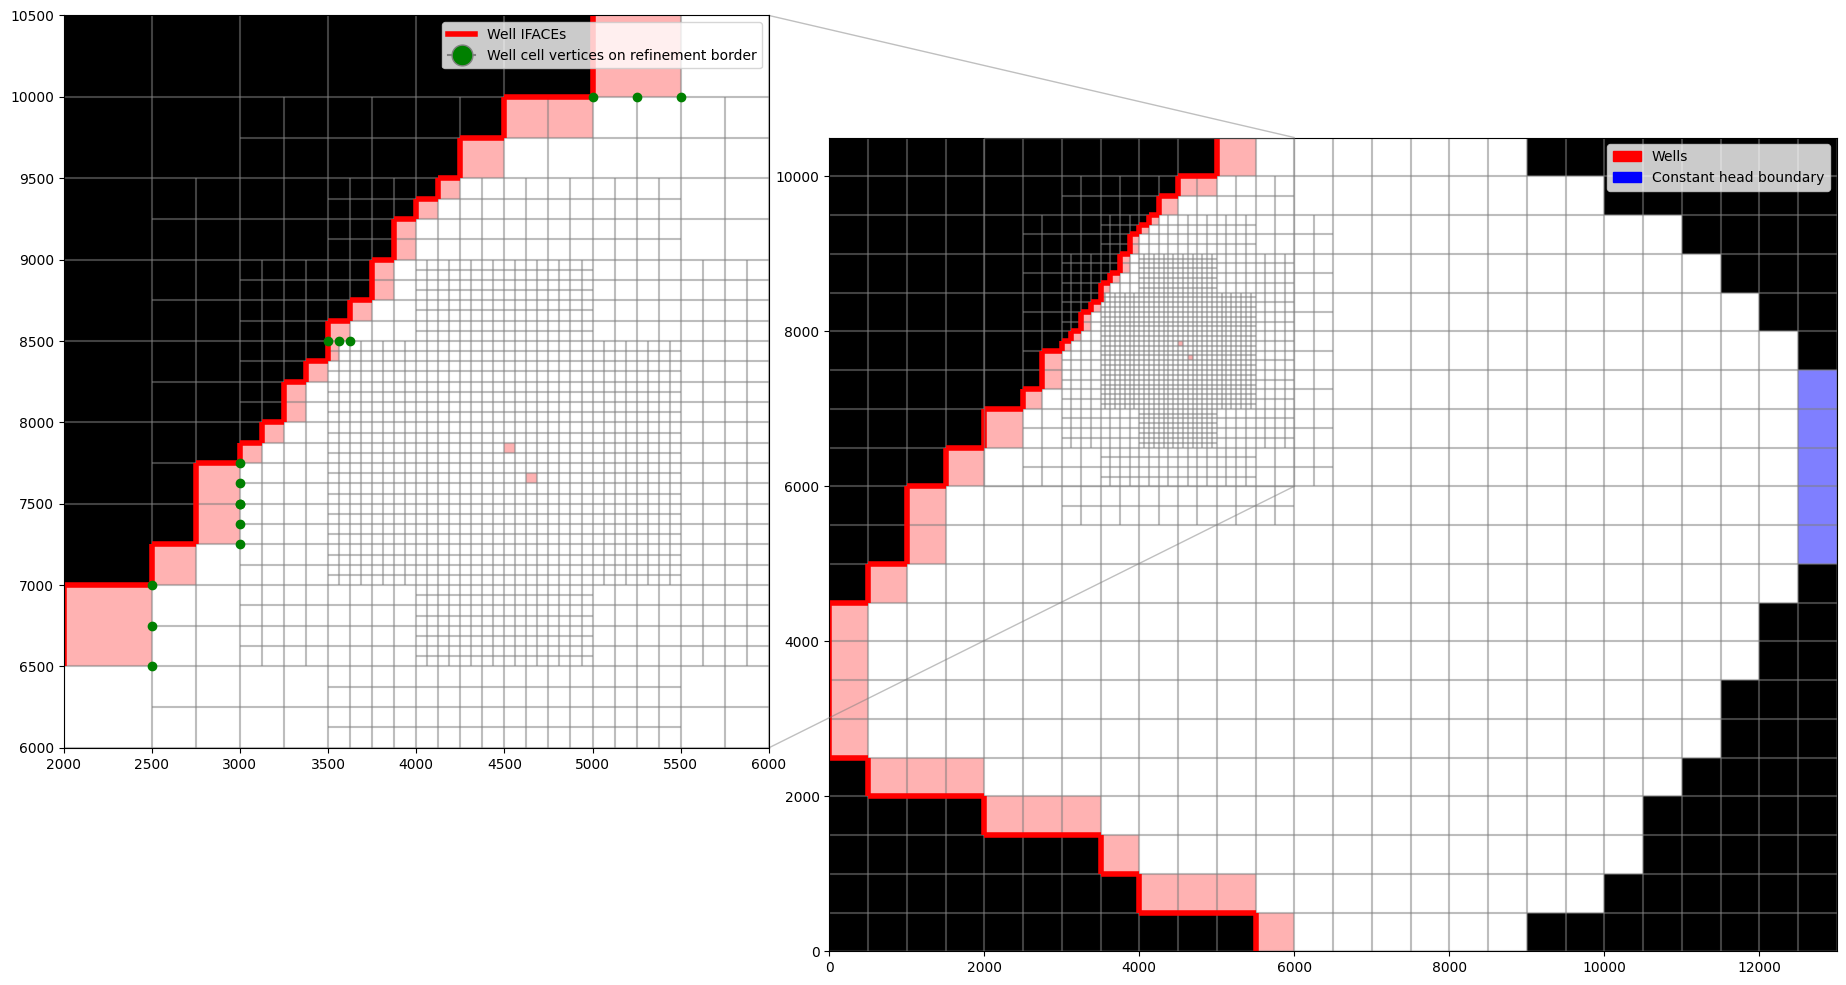

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mp7-p04...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package wel_0...
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 5 based on size of stress_period_data
    writing package oc...
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.4.1prt (preliminary) 06/15/2023
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jun 15 2023 01:33:40 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timel

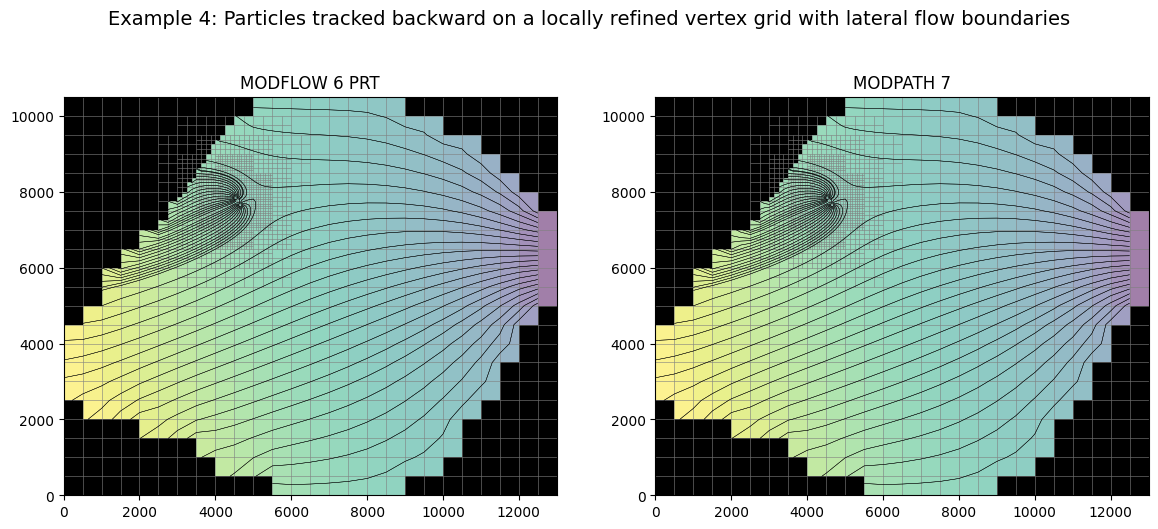

AssertionError: PRT Binary track data and MP7 pathline data shapes do not match: (1946,) != (2045,)

In [48]:
scenario()